In [1]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "tiny"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))

In [2]:
# Common Stuff
provider_region_mapping = {}
provider_region_mg_df = df.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index()
provider_region_mg_df
for index, row in provider_region_mg_df.iterrows():
    for measure_group in row['measure group']:
        region = row['region']
        provider = row['provider']
        measure_group = row['measure group'][0]
        provider_region_mapping[f"({provider}, {region})"] = {'region': region, 'measure group': measure_group, 'provider': provider}
        provider_region_mapping[f"({provider}, {region}, {measure_group})"] = {'region': region, 'measure group': measure_group, 'provider': provider}

# Mean Runtime and CV

AWS


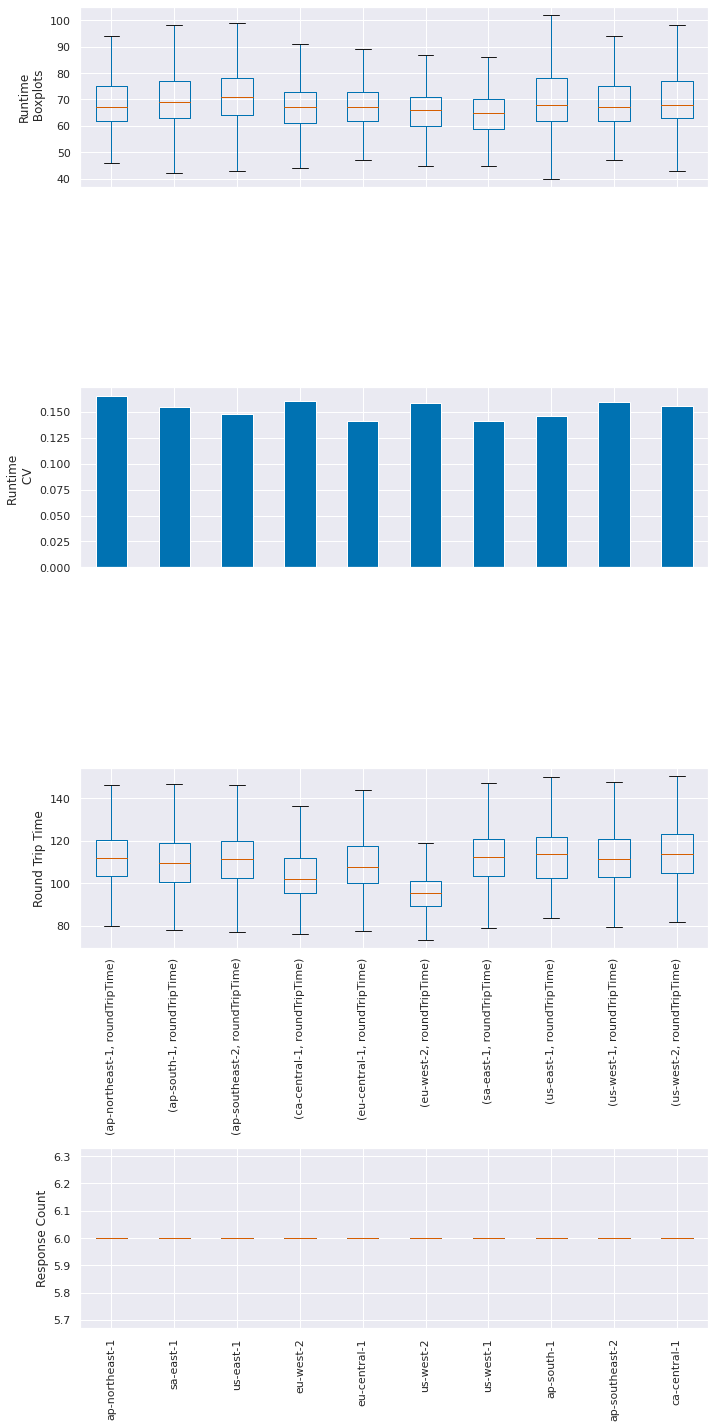

boxplot 
                 runtime                                                     
                  count       mean        std   min   25%   50%   75%    max
region                                                                      
ap-northeast-1  17370.0  69.449914  11.498890  33.0  62.0  67.0  75.0  446.0
ap-south-1      17364.0  70.704676  10.913137  42.0  63.0  69.0  77.0  231.0
ap-southeast-2  17375.0  71.127482  10.546134  40.0  64.0  71.0  78.0  241.0
ca-central-1    17382.0  68.036762  10.909589  40.0  61.0  67.0  73.0  246.0
eu-central-1    17370.0  68.289983   9.618368  35.0  62.0  67.0  73.0  170.0
eu-west-2       17358.0  67.141030  10.623037  39.0  60.0  66.0  71.0  567.0
sa-east-1       17364.0  65.866563   9.318072  36.0  59.0  65.0  70.0  178.0
us-east-1       17309.0  70.228840  10.279165  31.0  62.0  68.0  78.0  222.0
us-west-1       17358.0  69.494815  11.071164  47.0  62.0  67.0  75.0  330.0
us-west-2       17316.0  70.398706  10.962344  38.0  63.0  68.0  7

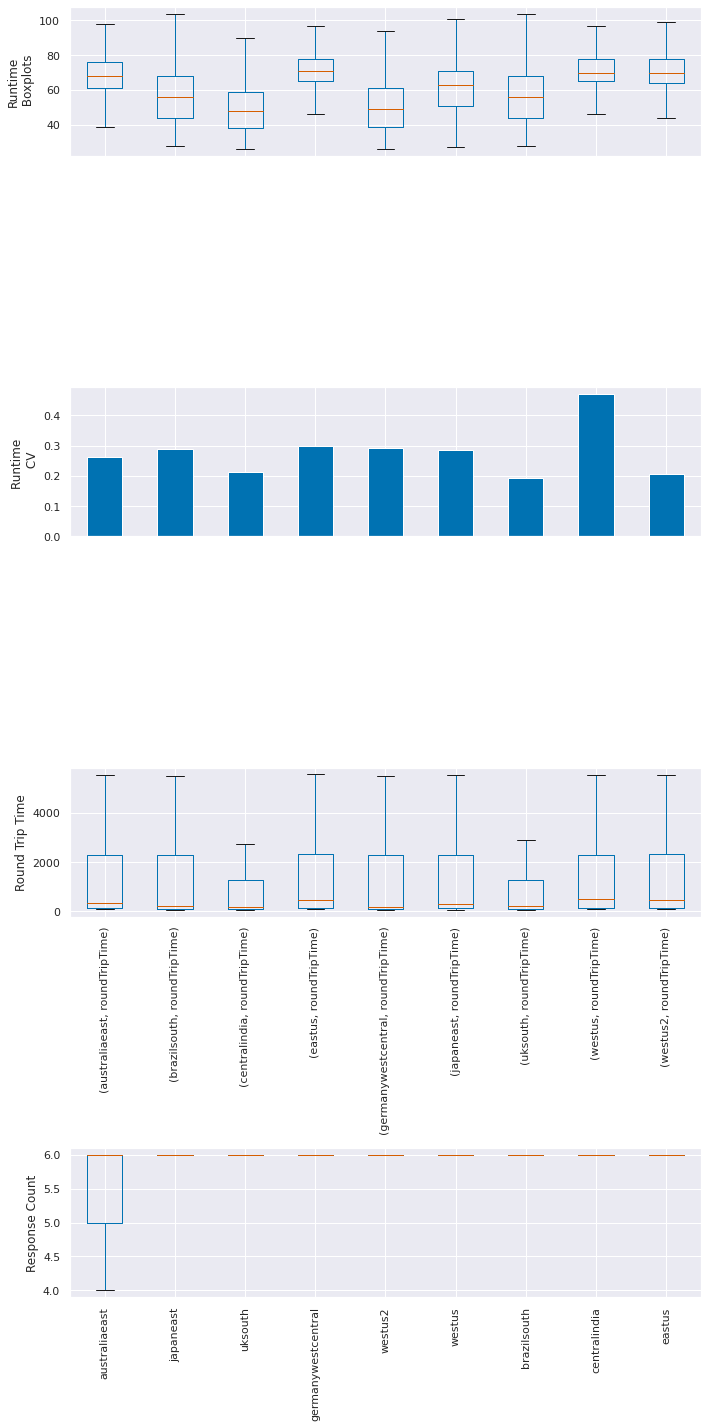

boxplot 
                     runtime                                                \
                      count       mean        std   min   25%   50%   75%   
region                                                                      
australiaeast       14768.0  69.747765  14.807410  39.0  61.0  68.0  76.0   
brazilsouth         17152.0  57.161206  16.292097  28.0  44.0  56.0  68.0   
centralindia        17298.0  49.828362  14.368943  26.0  38.0  48.0  59.0   
eastus              17105.0  73.323414  14.246454  42.0  65.0  71.0  78.0   
germanywestcentral  17309.0  51.202322  15.262342  26.0  39.0  49.0  61.0   
japaneast           17294.0  61.974789  16.320018  27.0  51.0  63.0  71.0   
uksouth             17303.0  57.489510  16.833038  28.0  44.0  56.0  68.0   
westus              16504.0  72.765148  34.187493  44.0  65.0  70.0  78.0   
westus2             17229.0  72.876197  14.937189  39.0  64.0  70.0  78.0   

                            
                       max  
region 

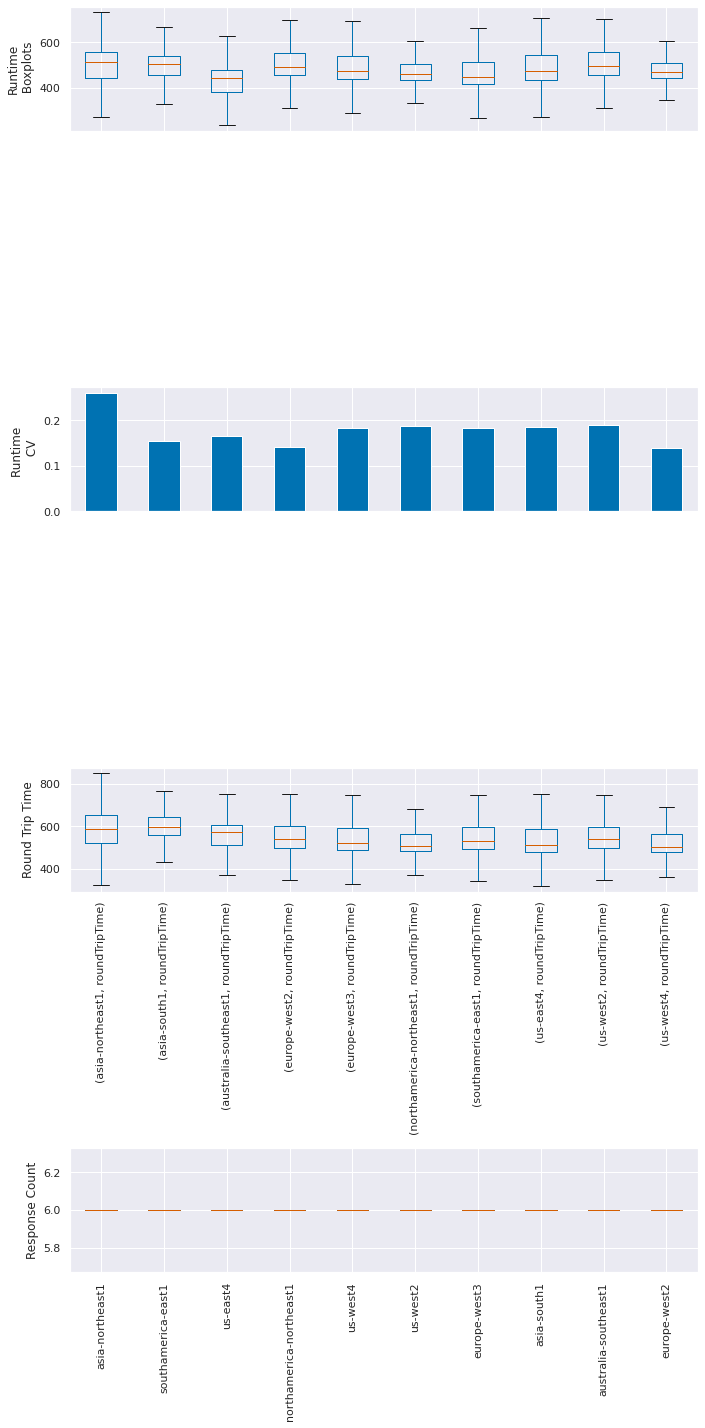

boxplot 
                          runtime                                               \
                           count        mean         std    min    25%    50%   
region                                                                          
asia-northeast1          17399.0  512.240703  132.788691  146.0  445.0  512.0   
asia-south1              17401.0  504.527383   78.153693  171.0  455.0  504.0   
australia-southeast1     17405.0  436.331456   71.910657  150.0  383.0  444.0   
europe-west2             17400.0  498.717184   92.964757  153.0  456.0  491.0   
europe-west3             17403.0  484.635120   88.416021  176.0  440.0  474.0   
northamerica-northeast1  17400.0  465.446092   65.125431  152.0  437.0  462.0   
southamerica-east1       17397.0  456.039949   83.640062  130.0  416.0  446.0   
us-east4                 17403.0  485.229845   89.532139  190.0  436.0  473.0   
us-west2                 17400.0  499.634598   94.265091  134.0  458.0  494.0   
us-west4          

In [30]:
cov_df = df.groupby( ['measure group', 'provider', 'region'], observed=True)['runtime'].apply(utils.cov).reset_index(name='Runtime CV').set_index(['provider', 'region'])
# cov_df = cov_df.sort_values(by=['measure group', 'provider', 'region'])

# TODO: Fix the issue with plotting.

for provider in cov_df.index.get_level_values('provider').unique():
    fig, axes = plt.subplots(figsize=(10,20), nrows=4, frameon=False, sharex=True)
    
    # Runtime
    bxdf = df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['region'], observed=True)
    utils.boxplot(axes[0], bxdf, "Runtime\n Boxplots", lambda x: x, 90)
    
    # COV
    cov_provider = cov_df[cov_df.index.isin([provider], level='provider')]
    cov_provider = cov_provider.reset_index().set_index('region')
    cov_provider.plot(kind='bar', ax=axes[1], sharex=True)
    axes[1].get_legend().remove()
    axes[1].set_ylabel('Runtime \n CV')
    
    # Round Trip Time
    rtt_df = df[['provider', 'region', 'roundTripTime']][df['provider'] == provider].groupby(['region'], observed=True)
    utils.boxplot(axes[2], rtt_df, 'Round Trip Time', lambda x: x, 90)
       
    # resp df
    resp_df = df[df['provider'] == provider].groupby( ['provider', 'region', 'driver_invocation'], observed=True).size().reset_index(name='counts')
    df_boxplot = resp_df[['provider', 'region', 'counts']].sort_values(by=['provider']).groupby(['region'], observed=True)
    ax = utils.boxplot(axes[3], df_boxplot, 'Response Count', utils.tick_get_1st, 90)
    
    region_name_ax = ax

    # Set Region Names
    
    labels = []
    for tick in region_name_ax.get_xticklabels():
        key = f"({provider}, {tick.get_text()})"
        mapping = provider_region_mapping[key]
        region = mapping['region']
        measure_group = mapping['measure group']
        labels.append(f"{measure_group}\n({region})")

    # region_name_ax.get_legend().remove()
    # region_name_ax.set_xticklabels(labels)
    # region_name_ax.set_xlabel('')

    fig.tight_layout()

    print(provider)
    utils.plot(f'ra_mean_runtime_{provider}', boxplot=bxdf.describe(), cov=cov_provider)

In [27]:
bxdf.count().index

CategoricalIndex(['asia-northeast1', 'asia-south1', 'australia-southeast1',
                  'europe-west2', 'europe-west3', 'northamerica-northeast1',
                  'southamerica-east1', 'us-east4', 'us-west2', 'us-west4'],
                 categories=['ap-northeast-1', 'ap-south-1', 'ap-southeast-2', 'asia-northeast1', 'asia-south1', 'australia-southeast1', 'australiaeast', 'brazilsouth', ...], ordered=False, dtype='category', name='region')

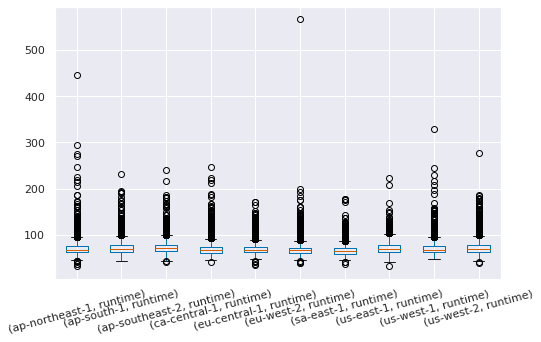

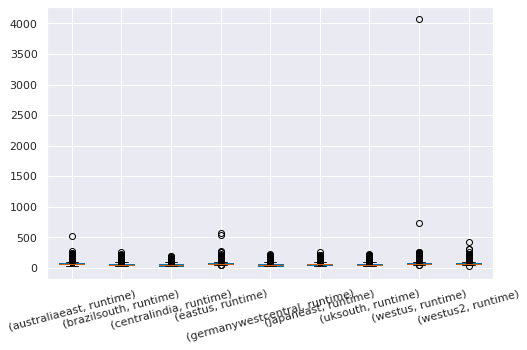

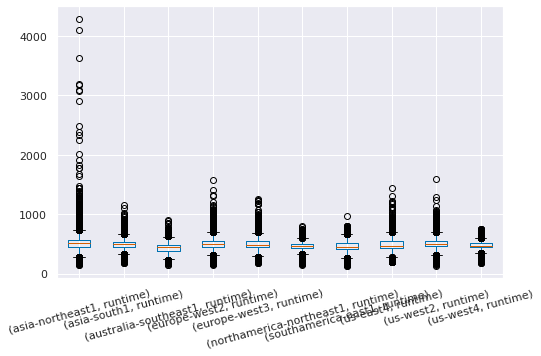

In [4]:
# Mean Runtime with Outliers
for provider in cov_df.index.get_level_values('provider').unique():
# Generate a control figure - because I cannot fore the matching
    fig, axes = plt.subplots(figsize=(8,5))
    df[['provider', 'region', 'runtime']][df['provider'] == provider].groupby(['region'], observed=True).boxplot(subplots=False, ax=axes, rot=45)
    for tick in axes.get_xticklabels():
        tick.set_rotation(15)
    plt.show()
    plt.close()

# CPU Types Analysis

In [5]:
unique_cpu_types_df = df.groupby(['measure group', 'provider', 'region'], observed=True)['cpuType'].unique()
unique_cpu_types_count_df = df.groupby(['measure group', 'provider', 'region'], observed=True)['cpuType'].nunique()
unique_cpu_types_count_per_invocation_df = df.groupby(['measure group', 'provider', 'region', 'driver_invocation'], observed=True)['cpuType'].nunique().reset_index()
unique_cpu_types_df, unique_cpu_types_count_df, unique_cpu_types_count_per_invocation_df.groupby(['provider', 'region']).describe()

(measure group   provider  region                 
 Japan           AWS       ap-northeast-1             ['Intel(R) Xeon(R) Processor @ 2.50GHz - Model...
                 AZURE     japaneast                  ['Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz - ...
                 GCP       asia-northeast1            ['unknown - Model 85', 'unknown - Model 79', '...
 India           AWS       ap-south-1                 ['Intel(R) Xeon(R) Processor @ 2.50GHz - Model...
                 AZURE     centralindia               ['Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60G...
                 GCP       asia-south1                ['unknown - Model 85']
 Categories (9, object):...
 Australia       AWS       ap-southeast-2             ['Intel(R) Xeon(R) Processor @ 2.50GHz - Model...
                 AZURE     australiaeast              ['Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GH...
                 GCP       australia-southeast1       ['unknown - Model 79', 'unknown - Model 85']
 C...
 Canada    

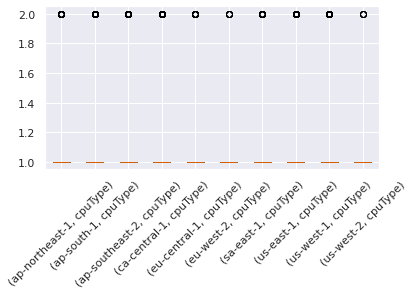

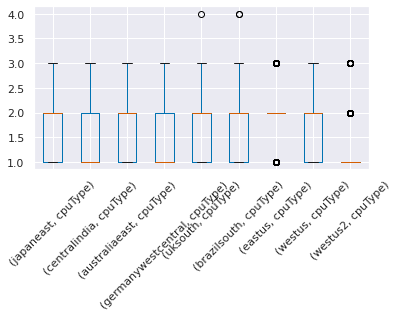

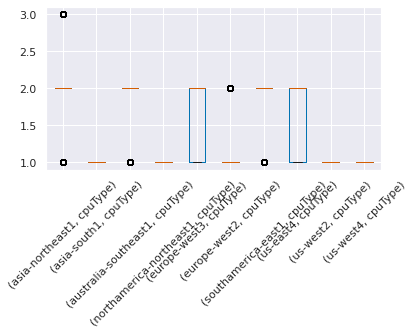

In [6]:
# Boxplots over CPUs per Invocation
for provider in unique_cpu_types_count_per_invocation_df['provider'].unique():
  fig, axes = plt.subplots(figsize=(6,3), nrows=1, ncols=1, frameon=False)
  unique_cpu_types_count_per_invocation_df[unique_cpu_types_count_per_invocation_df['provider'] == provider].groupby('region', observed=True).boxplot(subplots=False, rot=45, ax=axes)
  utils.plot(f'ra_cpu_types_in_invocation_{provider}')